<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/main/example_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# --- CONFIG: point these at your repo ---
REPO_URL = "https://github.com/cincysam6/Field_Control_Model.git"
REPO_DIR = "/content/Field_Control_Model"      # where to clone
PKG_ROOT = REPO_DIR                             # path to add to sys.path
REMOTE = "origin"
BRANCH = "main"                                 # or 'master' if you use that

# If your repo is private, set a token (or leave as None for public)
GITHUB_TOKEN = None  # e.g., "ghp_xxx..." or None for public

# ------------- helper: clone or pull -------------
import os, sys, subprocess, textwrap

def _run(cmd, cwd=None, check=True):
    print(" ".join(cmd))
    return subprocess.run(cmd, cwd=cwd, check=check, text=True, capture_output=True)

def ensure_repo(repo_url: str, repo_dir: str, remote="origin", branch="main", token=None, hard_reset=False):
    # Support private repos via token
    if token and repo_url.startswith("https://"):
        repo_url = repo_url.replace("https://", f"https://{token}@")

    if not os.path.exists(repo_dir):
        print(f"Cloning into {repo_dir} ...")
        _run(["git", "clone", "--recursive", repo_url, repo_dir])
    else:
        print(f"Repo exists at {repo_dir}. Fetching updates ...")
        _run(["git", "fetch", remote], cwd=repo_dir)
        if hard_reset:
            print(f"Hard resetting to {remote}/{branch} ...")
            _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)
        else:
            print("Pulling latest changes ...")
            # Fast-forward only; avoids merge prompts in Colab
            try:
                _run(["git", "pull", "--ff-only", remote, branch], cwd=repo_dir)
            except subprocess.CalledProcessError as e:
                print("Fast-forward failed (local changes?). Falling back to hard reset.")
                _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)

    # Ensure on the right branch
    _run(["git", "checkout", branch], cwd=repo_dir)

# ------------- do the fetch/pull -------------
ensure_repo(REPO_URL, REPO_DIR, remote=REMOTE, branch=BRANCH, token=GITHUB_TOKEN, hard_reset=False)

# ------------- put repo on sys.path -------------
if PKG_ROOT not in sys.path:
    sys.path.append(PKG_ROOT)

# ------------- turn on autoreload -------------
%load_ext autoreload
%autoreload 2

print("✅ Repo ready, path set, autoreload ON.")


Repo exists at /content/Field_Control_Model. Fetching updates ...
git fetch origin
Pulling latest changes ...
git pull --ff-only origin main
git checkout main
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Repo ready, path set, autoreload ON.


In [147]:
# 1. Clone your repo
#!git clone https://github.com/cincysam6/Field_Control_Model.git

# 2. Add it to Python path
import sys
#sys.path.append('/content/Field_Control_Model')

# 3. Import your helper function
from src.helpers import compute_distances_by_frame, pick_panel_kwargs,update_kwargs
from src.diagnostic_plots import plot_dir_orientation_small_multiples,diagnostic_plot,plot_field_control_small_multiples,diagnostic_multiples
from src.field_control_model import PlayerInfluenceModel
from src.compute_player_density import compute_player_densities_dataframe
from src.plot_player_density import plot_player_densities_from_dataframe, plot_team_densities_small_multiples


In [148]:
import pandas as pd

In [149]:
df = pd.read_csv('/content/drive/MyDrive/BDB_Data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [150]:
# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-2934120900.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [151]:
### Selecting a single player ID to test this out
one_player = [40488.0]
single_player = df[df['nflId'].isin(one_player)]

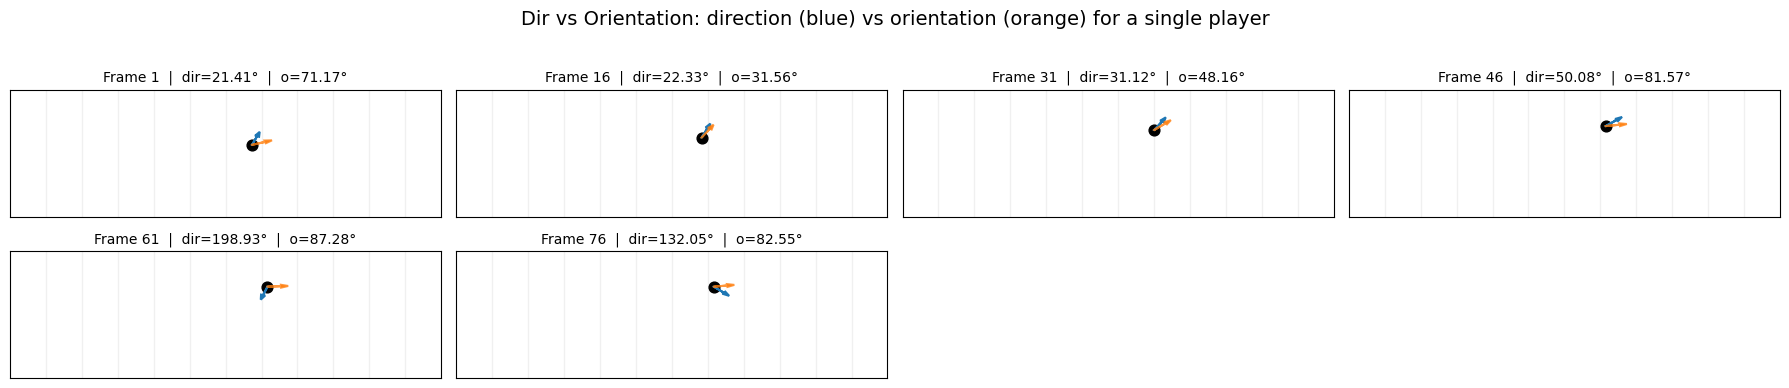

In [152]:
# df_player: rows for a single nflId on a single play
fig, axes = plot_dir_orientation_small_multiples(
    single_player,
    base_frame=int(single_player["frameId"].min()),
    offsets=(0, 15, 30, 45, 60, 75),
    arrow_len=5.0,
    scale_with_speed=True,
    show=True,
)

In [153]:
# --------------------------------------------------------------------------- #
# Canonical default configuration for PlayerInfluenceModel
# --------------------------------------------------------------------------- #

model_kwargs: dict = dict(
    # ---------------- Grid resolution / field dimensions ---------------- #
    grid_x_res=200,      # number of points in X direction (field length)
    grid_y_res=100,      # number of points in Y direction (field width)
    field_x_max=120.0,   # field length in yards (NFL standard includes end zones)
    field_y_max=53.3,    # field width in yards (NFL standard)

    # ---------------- Orientation bias ---------------------------------- #
    orientation_bias_deg=0.0,
    # Adds a fixed angular offset (deg) to player headings.
    # Default = 0.0 (no bias). Mainly for debugging or experimental asymmetry.

    # ---------------- Gaussian component -------------------------------- #
    gaussian_scale_factor=0.7,
    # Scales the Gaussian ellipse size. Larger → more diffuse influence.

    # ---------------- Gamma component ----------------------------------- #
    alpha_gamma=11.0,
    # Shape parameter of gamma distribution; controls forward density shape.
    beta_min=1.0,
    beta_max=20.0,
    # Dynamic beta depends on speed; clipped between [beta_min, beta_max].
    gamma_midpoint=15.0,
    # Speed (yards/s) where beta ramp is centered; affects how reach scales.
    gamma_scale_factor=0.8,
    # Multiplicative shrink/expand factor for gamma influence footprint.
    max_forward_distance=20.0,
    # Cutoff distance (yards) beyond which gamma influence fades.
    forward_decay_factor=1.0,
    # Controls exponential decay after the forward cutoff. Higher = slower fade.

    # ---------------- Angular cone filtering ----------------------------- #
    angle_limit_min=15.0,
    # Cone half-angle (deg) at very high speed (narrow).
    angle_limit_max=45.0,
    # Cone half-angle (deg) at very low speed (wide).
    angle_decay_factor=2.0,
    # How fast cone narrows with speed. Lower = cone shrinks more quickly.

    # ---------------- Mixture weights (Gaussian vs Gamma) ---------------- #
    w_gaussian_min=0.2,
    # Minimum Gaussian weight (at very high speed).
    w_gaussian_max=1.0,
    # Maximum Gaussian weight (at near-zero speed).
    gaussian_midpoint=4.0,
    # Logistic midpoint: speed (yd/s) where weights are ~50/50.
    gaussian_steepness=2.0,
    # Logistic steepness: how sharply weights transition around midpoint.
)


In [154]:

model = PlayerInfluenceModel(**model_kwargs)

# 1) Compute influence for exactly one player in one frame
player_id = 40488.0
frame_id  = 150

single = model.compute_influence(
    df=df,                         # your tracking rows for the play
    frame_id=frame_id,
    player_ids=[player_id],
    id_col="nflId",
    name_col="displayName",
    x_col="x",
    y_col="y",
    speed_col="s",
    dir_col="dir",
    dist_from_ball_col="dist_from_football",
    density_out_col="density"      # put the 2D array here
)

# 2) Pull out the 2D density array for this (frame, player)
if single.empty:
    raise ValueError("No rows returned; check frame_id/player_id.")
Z = single.iloc[0]["density"]          # shape (ny, nx), a NumPy array

# 3) Turn the density into a neat table with x/y coordinates as index/columns
X, Y = model.grid.X, model.grid.Y
density_table = pd.DataFrame(Z, index=model.grid.y_vals, columns=model.grid.x_vals)

# Optional: a tiny summary “table” of stats for this player/frame
stats = pd.DataFrame({
    "frameId": [frame_id],
    "nflId": [player_id],
    "sum_density": [float(Z.sum())],
    "max_density": [float(Z.max())],
    "center_of_mass_x": [float((X * Z).sum() / (Z.sum() + 1e-9))],
    "center_of_mass_y": [float((Y * Z).sum() / (Z.sum() + 1e-9))],
})

# What you now have:
# - `single` : one-row DataFrame with player/pose fields + the 'density' array
# - `density_table` : a tidy grid (rows=y, cols=x) suitable for inspection/plotting
# - `stats` : a compact summary for quick comparisons



In [155]:
frames = range(120, 161, 1)  # inclusive-ish range if it matches your data
rows = []

for fid in frames:
    out = model.compute_influence(
        df=df,
        frame_id=fid,
        player_ids=[player_id],
        density_out_col="density",
    )
    if out.empty:
        continue
    r = out.iloc[0].copy()
    r["sum_density"] = float(r["density"].sum())
    rows.append(r)

player_frames = pd.DataFrame(rows)  # one row per frame for that player

# If you want a dict of density tables keyed by frame:
density_by_frame = {
    int(r.frameId): pd.DataFrame(r.density, index=model.grid.y_vals, columns=model.grid.x_vals)
    for _, r in player_frames.iterrows()
}


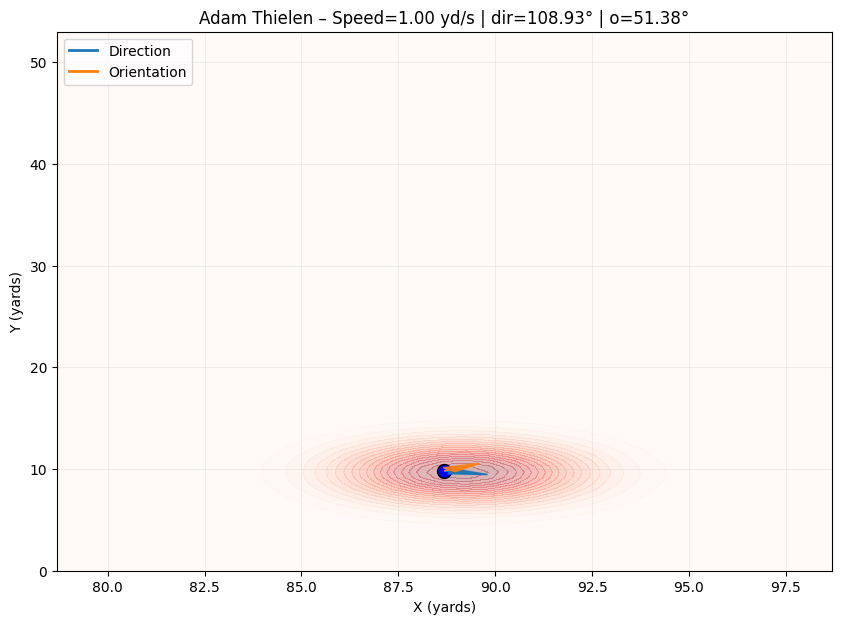

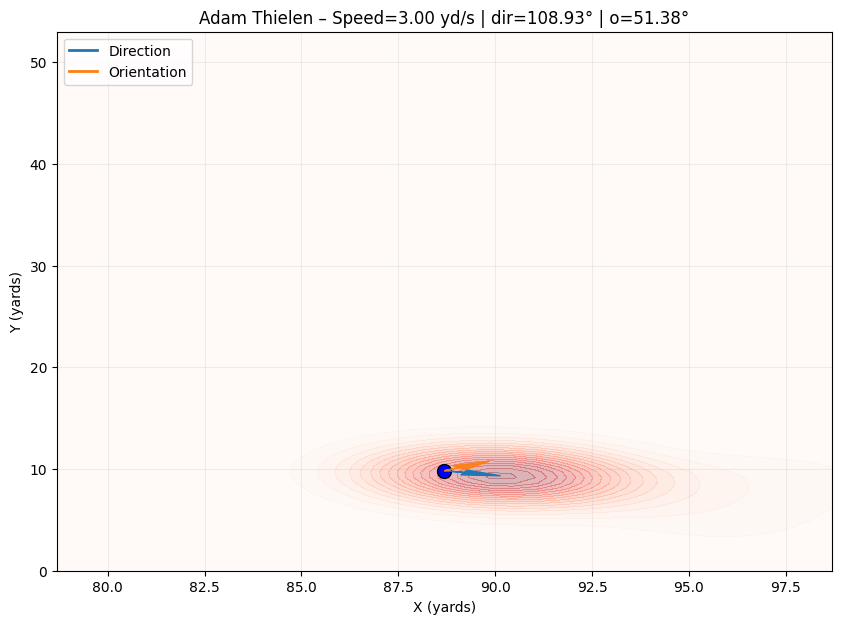

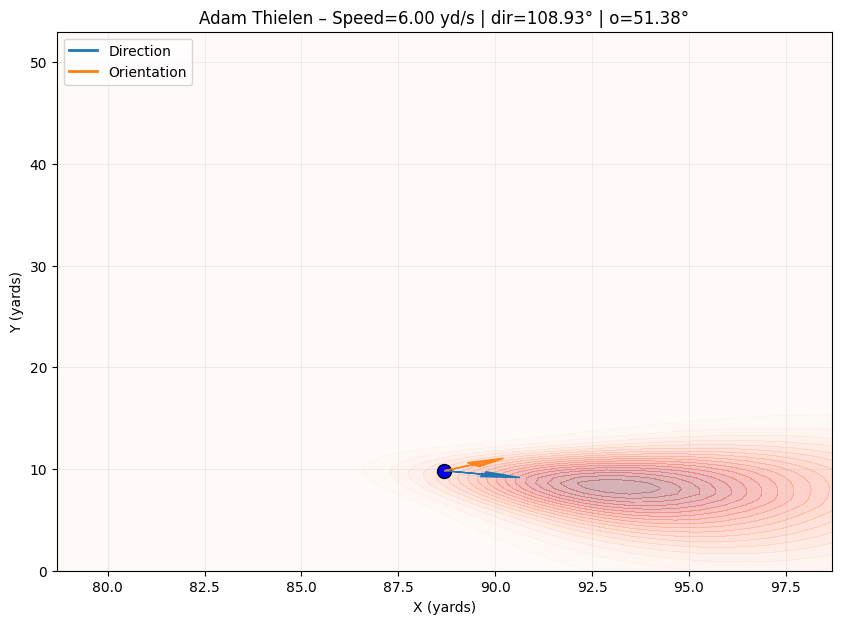

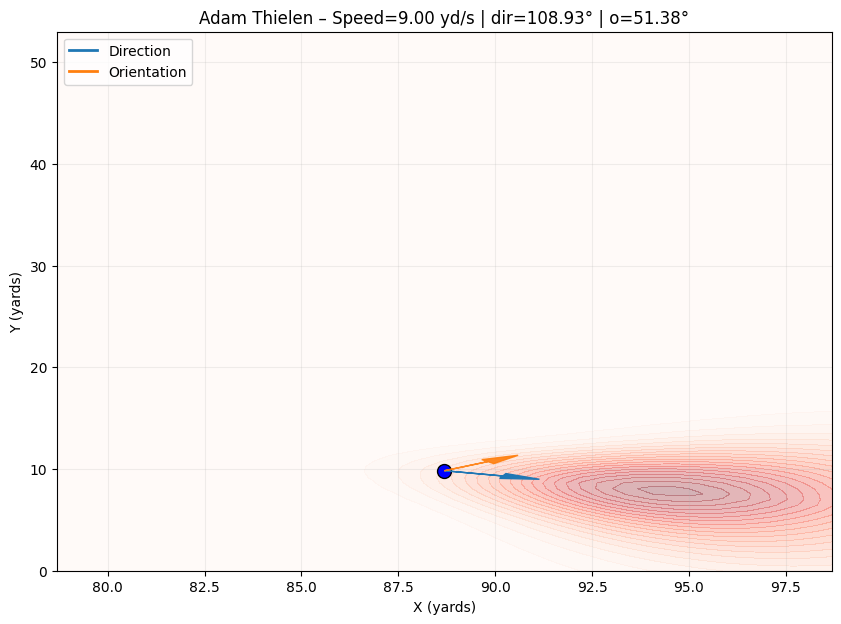

In [156]:

diagnostic_plot(df,
                frame_id=150,
                player_ids=[40488],
                speeds=(1,3, 6, 9),
                model_kwargs=model_kwargs,
                arrow_scale=2.0,    # instead of 5.0
                arrow_head_width=0.5,
                arrow_head_length=1.0,)




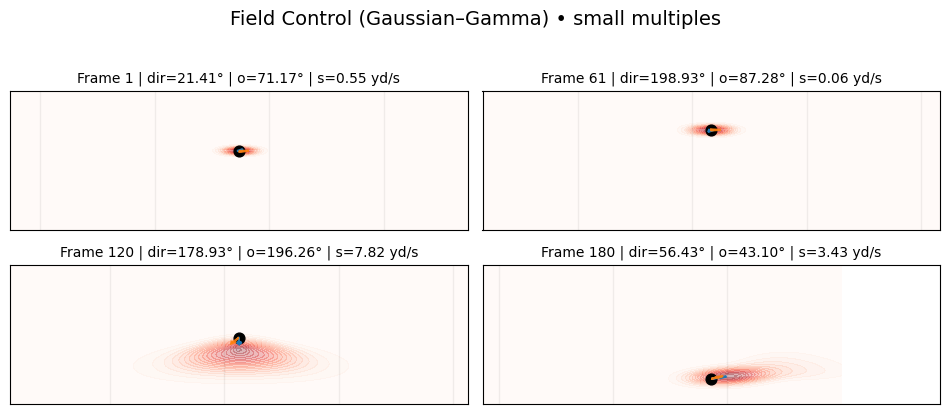

In [157]:
# Assume `one_player_df` is already filtered to a single player's rows

fig, axes, frames = plot_field_control_small_multiples(
    single_player,
    cols=2,
    n_panels=4,
    model_kwargs=model_kwargs,
    arrow_scale=2.5,          # smaller arrows
)


[Gaussian scale ↓] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.42, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 10.0}
[Gaussian scale ↑] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.9799999999999999, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint

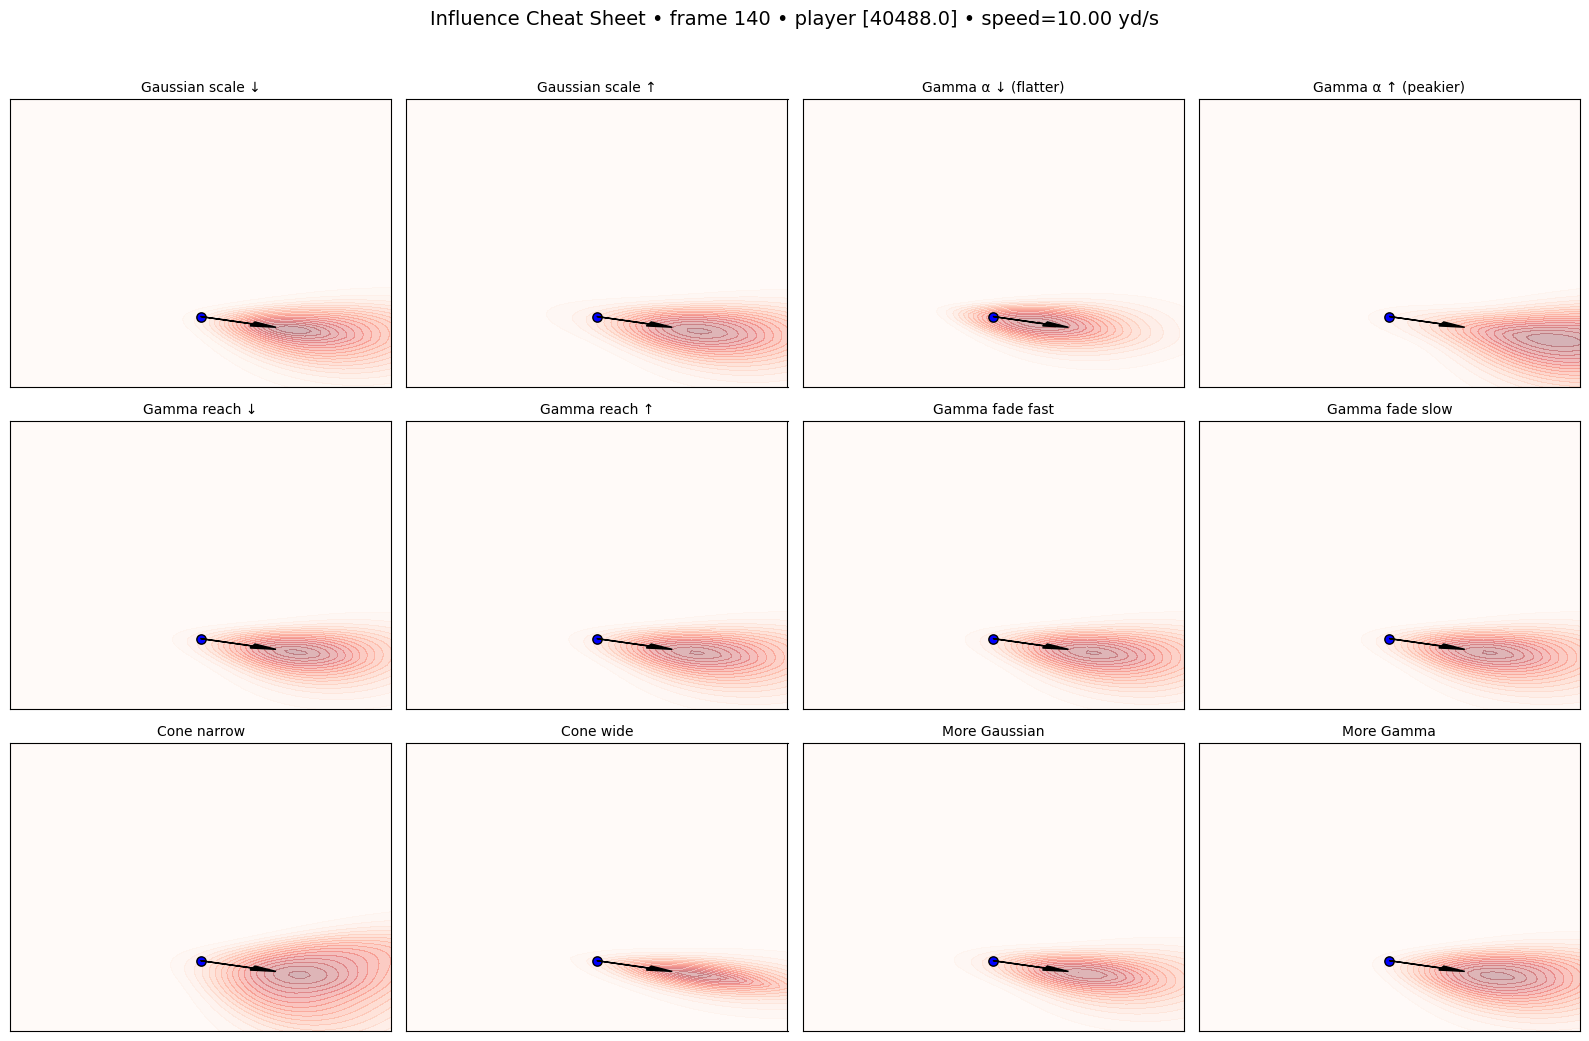

In [158]:


# 1) Run the cheat sheet — returns every panel’s params
fig, panels, params_df = diagnostic_multiples(
    df=df,
    frame_id=140,
    player_id=one_player,
    speed=10.0,
    model_kwargs=model_kwargs,
    verbose=True,   # prints the full dict for each panel
)





In [159]:
# 2) Pick a panel’s params, tweak a couple, and build a model
mk = pick_panel_kwargs(panels, title="Gamma reach ↑", updates={"alpha_gamma": 12.0})
print(mk)
new_model = PlayerInfluenceModel(**mk)

{'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.7, 'alpha_gamma': 12.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 28.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0}


[Gaussian scale ↓] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.42, 'alpha_gamma': 12.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 28.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 1.0}
[Gaussian scale ↑] {'grid_x_res': 200, 'grid_y_res': 100, 'field_x_max': 120.0, 'field_y_max': 53.3, 'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.9799999999999999, 'alpha_gamma': 12.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 28.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint'

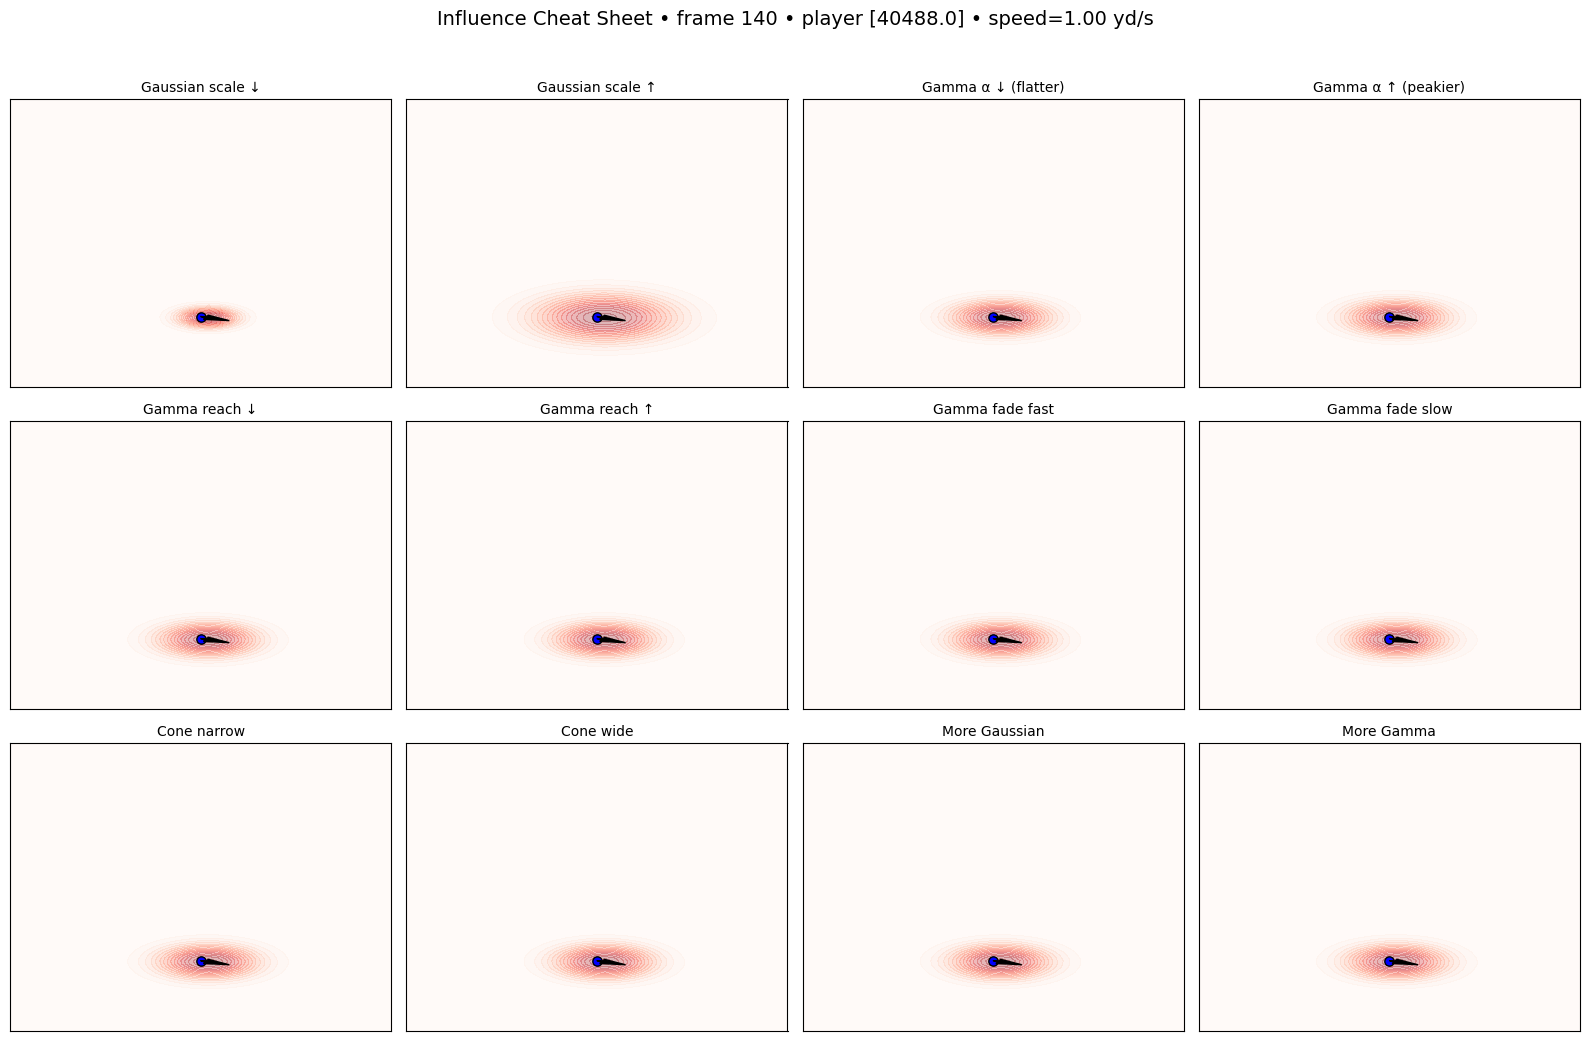

In [160]:

# 1) Run the cheat sheet — returns every panel’s params
fig, panels, params_df = diagnostic_multiples(
    df=df,
    frame_id=140,
    player_id=one_player,
    speed=1.0,
    model_kwargs=mk,
    verbose=True,   # prints the full dict for each panel
)


In [161]:
# 1. Pick your frame range for the play
min_frame, max_frame = 1, max(df['frameId'])   # example, adapt to your data

# 2. Compute all player densities
all_player_df, (X, Y) = compute_player_densities_dataframe(
    df=df,                # <-- your tracking dataframe
    min_frame=min_frame,
    max_frame=max_frame,
    model_kwargs=model_kwargs,
    exclude_football=True
)

# all_player_df now has one row per (frameId, nflId), with a "density" (2D np.array)
print(all_player_df.head())


   frameId    nflId     displayName  jerseyNumber      x          y  speed  \
0        1  38632.0    Kirk Cousins           8.0  68.13  31.343333   0.00   
1        1  40488.0    Adam Thielen          19.0  67.34  30.103333   0.55   
2        1  44834.0  Charles Harris          53.0  76.01  30.503333   0.00   
3        1  44888.0   Alex Anzalone          34.0  77.35  29.633333   0.01   
4        1  45094.0    Johnny Mundt          86.0  68.60  29.803333   1.40   

   direction  is_off  dist_from_football  theta_rad  orientation_bias_deg  \
0     206.72     1.0            6.201815   4.246037                   0.0   
1      21.41     1.0            6.730499   1.197121                   0.0   
2      78.90     0.0            2.227667   0.193732                   0.0   
3     107.30     0.0            3.314362   5.981243                   0.0   
4      32.31     1.0            5.450616   1.006880                   0.0   

                                             density  
0  [[0.0, 0.0

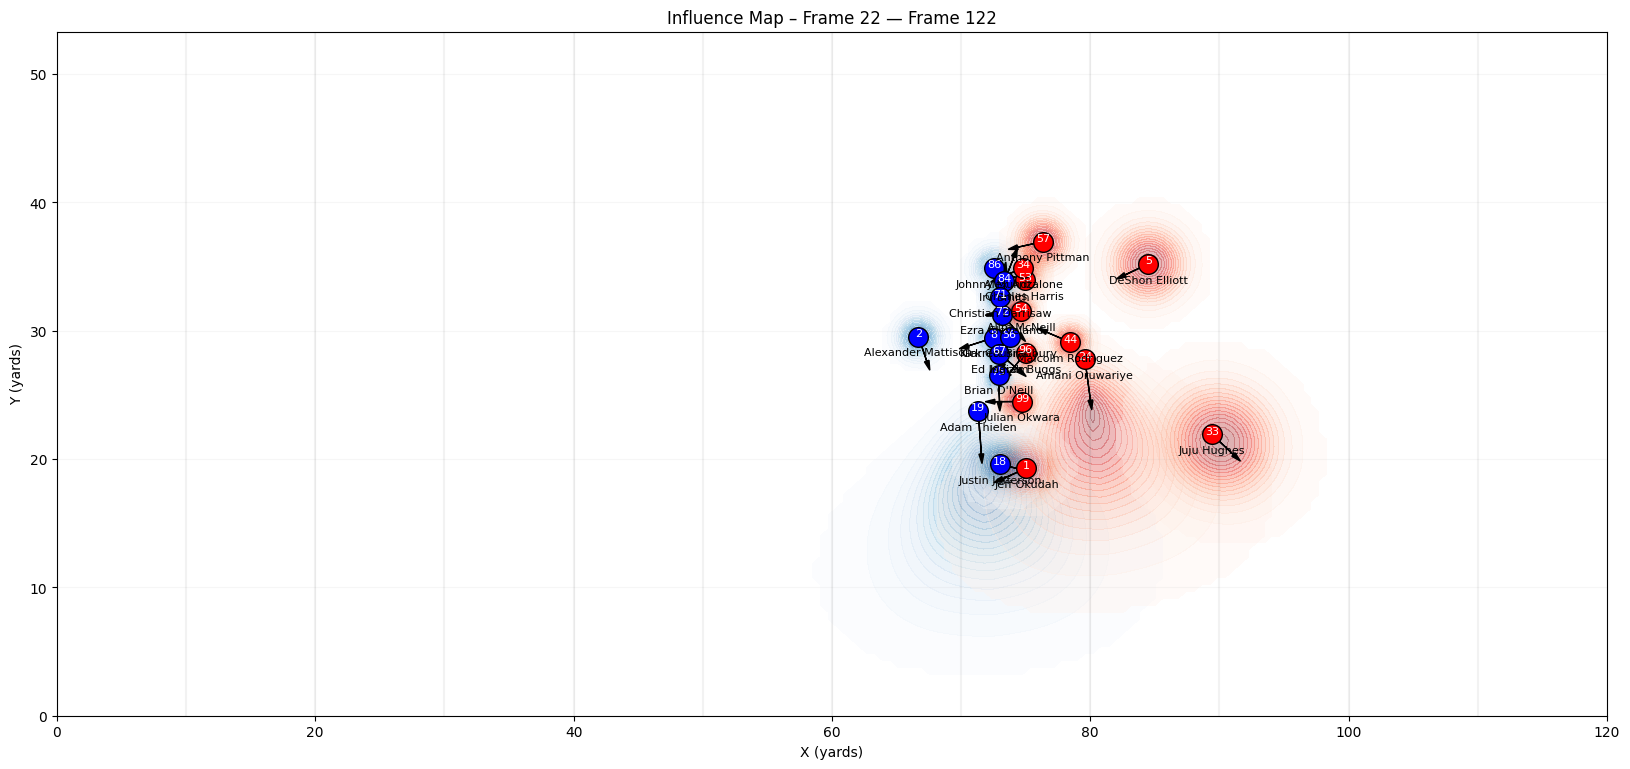

In [167]:
# Plot frame 22
fig, ax = plot_player_densities_from_dataframe(
    all_player_df,
    grid=(X, Y),                # can pass (X, Y) or model.grid
    frame_id=122,
    contour_levels=18,
    contour_alpha=0.3,
    off_cmap="Reds",
    on_cmap="Blues",
    arrow_scale=2.0,
    title="Influence Map – Frame 22"
)


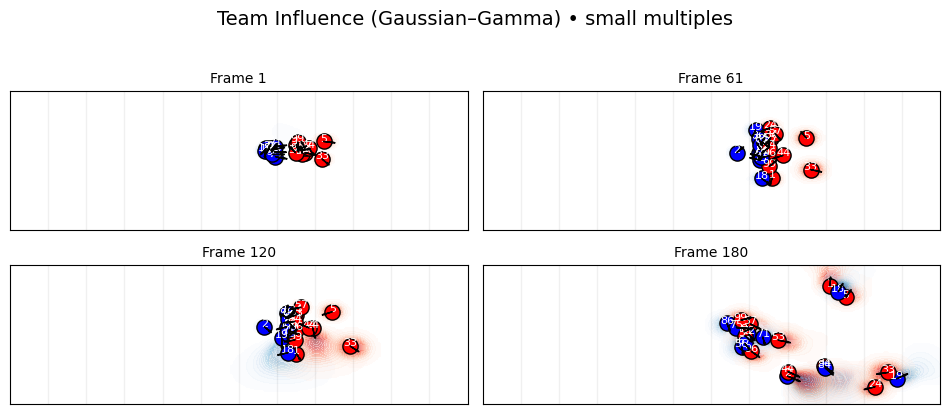

In [164]:
# 1) Zoom around the ball (per-frame)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df, (X, Y),
    n_panels=4, cols=2,
    zoom_mode="ball", zoom_width=24.0, zoom_height=24.0,
)




In [ ]:
# 2) Zoom around LOS; constant x=75 (e.g., set by your play metadata)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df, (X, Y),
    frames=[130,150,170,190,210,230],
    zoom_mode="los", los_x=75.0, zoom_width=30.0, zoom_height=26.0,
)

# 3) Zoom using per-frame LOS column (if present on player_df)
#    Add a 'los_x' value to at least one row per frame.
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df.assign(los_x=75.0), (X, Y),
    n_panels=6, cols=3, zoom_mode="los",
)

# 4) Fixed center (x,y)
fig, axes, used = plot_team_densities_small_multiples(
    all_player_df, (X, Y),
    zoom_mode="fixed", fixed_center=(80.0, 26.65), zoom_width=28.0, zoom_height=28.0,
)